In [ ]:
#@title
%%html
<div style="background-color: pink;">
  Notebook written in collaboration with <a href="https://github.com/aditya-malte">Aditya Malte</a>.
  <br>
  The Notebook is on GitHub, so contributions are more than welcome.
</div>
<br>
<div style="background-color: yellow;">
  Aditya wrote another notebook with a slightly different use case and methodology, please check it out.
  <br>
  <a target="_blank" href="https://gist.github.com/aditya-malte/2d4f896f471be9c38eb4d723a710768b">
    https://gist.github.com/aditya-malte/2d4f896f471be9c38eb4d723a710768b
  </a>
</div>


# How to train a new language model from scratch using Transformers and Tokenizers

### Notebook edition (link to blogpost [link](https://huggingface.co/blog/how-to-train)). Last update May 15, 2020


Over the past few months, we made several improvements to our [`transformers`](https://github.com/huggingface/transformers) and [`tokenizers`](https://github.com/huggingface/tokenizers) libraries, with the goal of making it easier than ever to **train a new language model from scratch**.

In this post we’ll demo how to train a “small” model (84 M parameters = 6 layers, 768 hidden size, 12 attention heads) – that’s the same number of layers & heads as DistilBERT – on **Esperanto**. We’ll then fine-tune the model on a downstream task of part-of-speech tagging.


## 1. Find a dataset

First, let us find a corpus of text in Esperanto. Here we’ll use the Esperanto portion of the [OSCAR corpus](https://traces1.inria.fr/oscar/) from INRIA.
OSCAR is a huge multilingual corpus obtained by language classification and filtering of [Common Crawl](https://commoncrawl.org/) dumps of the Web.

<img src="https://huggingface.co/blog/assets/01_how-to-train/oscar.png" style="margin: auto; display: block; width: 260px;">

The Esperanto portion of the dataset is only 299M, so we’ll concatenate with the Esperanto sub-corpus of the [Leipzig Corpora Collection](https://wortschatz.uni-leipzig.de/en/download), which is comprised of text from diverse sources like news, literature, and wikipedia.

The final training corpus has a size of 3 GB, which is still small – for your model, you will get better results the more data you can get to pretrain on. 



In [ ]:
# in this notebook we'll only get one of the files (the Oscar one) for the sake of simplicity and performance
!wget -c https://cdn-datasets.huggingface.co/EsperBERTo/data/oscar.eo.txt

## 2. Train a tokenizer

We choose to train a byte-level Byte-pair encoding tokenizer (the same as GPT-2), with the same special tokens as RoBERTa. Let’s arbitrarily pick its size to be 52,000.

We recommend training a byte-level BPE (rather than let’s say, a WordPiece tokenizer like BERT) because it will start building its vocabulary from an alphabet of single bytes, so all words will be decomposable into tokens (no more `<unk>` tokens!).


In [ ]:
# We won't need TensorFlow here
!pip uninstall -y tensorflow
# Install `transformers` from master
!pip install git+https://github.com/huggingface/transformers
!pip list | grep -E 'transformers|tokenizers'
# transformers version at notebook update --- 2.11.0
# tokenizers version at notebook update --- 0.8.0rc1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# with open('pgn/twic1431.pgn', 'r') as f:
#   lines = f.read().split('\n')
# print(lines[:20])

In [ ]:
%%time 
from pathlib import Path

# from tokenizers import ByteLevelBPETokenizer
from tokenizers import Tokenizer
from tokenizers.models import Unigram
from tokenizers.pre_tokenizers import Whitespace

base_dir = '/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks'

paths = ['/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/MacKenzie.pgn_simplified.spgn',
         '/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/twic1431g/twic1431.pgn_simplified.spgn']

print(paths)

# Initialize a tokenizer
# tokenizer = ByteLevelBPETokenizer()
tokenizer = Tokenizer(Unigram())
tokenizer.pre_tokenizer = Whitespace()

with open(f'{base_dir}/complete_vocab.txt', 'r') as f:
  vocab = f.read().split('\n')

vocab += ["<s>", "<pad>", "</s>", "<unk>", "<mask>"]
# Customize training
# tokenizer.train(files=paths, vocab_size=len(vocab), min_frequency=1, special_tokens=vocab)

from tokenizers.trainers import UnigramTrainer
trainer = UnigramTrainer(vocab_size=len(vocab), special_tokens=vocab)
tokenizer.train(files=paths, trainer=trainer)

['/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/MacKenzie.pgn_simplified.spgn', '/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/twic1431g/twic1431.pgn_simplified.spgn']
CPU times: user 1.27 s, sys: 1.42 s, total: 2.69 s
Wall time: 2.28 s


In [ ]:
output = tokenizer.encode("e4 e5 Nf3 Nf6 d4 Nxe4 Bd3 d5 dxe5")
print(output.tokens)
print(len(vocab))

['e4', 'e5', 'Nf3', 'Nf6', 'd4', 'Nxe4', 'Bd3', 'd5', 'dxe5']
14731


Now let's save files to disk

In [ ]:
# !mkdir pgnBERT
# tokenizer.save_model("pgnBERT")
tokenizer.model.save("/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/pgnBERT")
tokenizer.save("/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/pgnBERT/tokenizer.json")

🔥🔥 Wow, that was fast! ⚡️🔥

We now have both a `vocab.json`, which is a list of the most frequent tokens ranked by frequency, and a `merges.txt` list of merges.

```json
{
	"<s>": 0,
	"<pad>": 1,
	"</s>": 2,
	"<unk>": 3,
	"<mask>": 4,
	"!": 5,
	"\"": 6,
	"#": 7,
	"$": 8,
	"%": 9,
	"&": 10,
	"'": 11,
	"(": 12,
	")": 13,
	# ...
}

# merges.txt
l a
Ġ k
o n
Ġ la
t a
Ġ e
Ġ d
Ġ p
# ...
```

What is great is that our tokenizer is optimized for Esperanto. Compared to a generic tokenizer trained for English, more native words are represented by a single, unsplit token. Diacritics, i.e. accented characters used in Esperanto – `ĉ`, `ĝ`, `ĥ`, `ĵ`, `ŝ`, and `ŭ` – are encoded natively. We also represent sequences in a more efficient manner. Here on this corpus, the average length of encoded sequences is ~30% smaller as when using the pretrained GPT-2 tokenizer.

Here’s  how you can use it in `tokenizers`, including handling the RoBERTa special tokens – of course, you’ll also be able to use it directly from `transformers`.


In [ ]:
# from tokenizers.implementations import ByteLevelBPETokenizer
# from tokenizers.implementations import Tokenizer
from tokenizers.processors import BertProcessing


# tokenizer = ByteLevelBPETokenizer(
#     "./pgnBERT/vocab.json",
#     "./pgnBERT/merges.txt",
# )
tokenizer = Tokenizer.from_file(
    "/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/pgnBERT/tokenizer.json",
)

In [ ]:
# tokenizer._tokenizer.post_processor = BertProcessing(
#     ("</s>", tokenizer.token_to_id("</s>")),
#     ("<s>", tokenizer.token_to_id("<s>")),
# )
# tokenizer.enable_truncation(max_length=512)

In [ ]:
tokenizer.encode("e4 e5 Nf3 Nf6 d4")

Encoding(num_tokens=5, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [ ]:
tokenizer.encode("e4 e5 Nf3 Nf6 d4").tokens

['e4', 'e5', 'Nf3', 'Nf6', 'd4']

## 3. Train a language model from scratch

**Update:** This section follows along the [`run_language_modeling.py`](https://github.com/huggingface/transformers/blob/master/examples/legacy/run_language_modeling.py) script, using our new [`Trainer`](https://github.com/huggingface/transformers/blob/master/src/transformers/trainer.py) directly. Feel free to pick the approach you like best.

> We’ll train a RoBERTa-like model, which is a BERT-like with a couple of changes (check the [documentation](https://huggingface.co/transformers/model_doc/roberta.html) for more details).

As the model is BERT-like, we’ll train it on a task of *Masked language modeling*, i.e. the predict how to fill arbitrary tokens that we randomly mask in the dataset. This is taken care of by the example script.


In [ ]:
# Check that we have a GPU
!nvidia-smi

Sun Apr 17 01:44:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Check that PyTorch sees it
import torch
torch.cuda.is_available()

True

### We'll define the following config for the model

In [ ]:
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=15011,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
)

Now let's re-create our tokenizer in transformers

In [ ]:
from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast.from_pretrained("/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/pgnBERT", max_len=512)

Finally let's initialize our model.

**Important:**

As we are training from scratch, we only initialize from a config, not from an existing pretrained model or checkpoint.

In [ ]:
from transformers import RobertaForMaskedLM

# model = RobertaForMaskedLM(config=config)
model = RobertaForMaskedLM.from_pretrained("/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/pgnBERT")

In [ ]:
model.num_parameters()
# => 84 million parameters

55059875

### Now let's build our training Dataset

We'll build our dataset by applying our tokenizer to our text file.

Here, as we only have one text file, we don't even need to customize our `Dataset`. We'll just use the `LineByLineDataset` out-of-the-box.

In [ ]:
%%time
from transformers import LineByLineTextDataset

dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path="/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/clean_joint_100.cpgn",
    block_size=128,
)

/usr/local/lib/python3.7/dist-packages/transformers/data/datasets/language_modeling.py:125: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  FutureWarning,


CPU times: user 1min 31s, sys: 6.62 s, total: 1min 37s
Wall time: 38 s


Like in the [`run_language_modeling.py`](https://github.com/huggingface/transformers/blob/master/examples/language-modeling/run_language_modeling.py) script, we need to define a data_collator.

This is just a small helper that will help us batch different samples of the dataset together into an object that PyTorch knows how to perform backprop on.

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

### Finally, we are all set to initialize our Trainer

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/pgnBERT",
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_gpu_train_batch_size=64,
    save_steps=10000,
    save_total_limit=2,
    prediction_loss_only=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
)

### Start training

In [ ]:
%%time
trainer.train()

#### 🎉 Save final model (+ tokenizer + config) to disk

In [ ]:
trainer.save_model("/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/pgnBERT")

Saving model checkpoint to /content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/pgnBERT
Configuration saved in /content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/pgnBERT/config.json
Model weights saved in /content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/pgnBERT/pytorch_model.bin


## 4. Check that the LM actually trained

Aside from looking at the training and eval losses going down, the easiest way to check whether our language model is learning anything interesting is via the `FillMaskPipeline`.

Pipelines are simple wrappers around tokenizers and models, and the 'fill-mask' one will let you input a sequence containing a masked token (here, `<mask>`) and return a list of the most probable filled sequences, with their probabilities.



In [ ]:
from transformers import pipeline

fill_mask = pipeline(
    "fill-mask",
    # model="./pgnBERT",
    # tokenizer="./pgnBERT",
    model="/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/pgnBERT",
    tokenizer="/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/pgnBERT",
    top_k=8,
)

In [ ]:
!pip install chess

In [ ]:
!pip install cairosvg

In [ ]:
import chess
import chess.pgn as pgn
import chess.svg
import io
import random
import numpy as np
from copy import copy

In [ ]:
game_end = ['1-0', '0-1', '1/2-1/2']

def is_legal(board, move):
  try:
    san_move = board.parse_san(move)
  except ValueError as e:
    return False
  return san_move in board.legal_moves

def sample_next_k(board, position, k):
  if k <= 0:
    return 0, []
  moves = fill_mask(' '.join(position) + ' <mask>')
  moves = [move for move in moves if move['token_str'] not in game_end]
  max_score = float('-inf')
  max_seq = []
  for move in moves:
    if is_legal(board, move['token_str']):
      board.push_san(move['token_str'])
      position.append(move['token_str'])
      score, subseq = sample_next_k(
          board,
          position,
          k - 1
      )
      score += np.log(move['score'])
      subseq.insert(0, move['token_str'])
      board.pop()
      position.pop()
      if score > max_score:
        max_score = score
        max_seq = copy(subseq)
  # if len(max_seq) == 0:
  #   print(k, ' '.join(position))
  #   print([move['token_str'] for move in moves])
  #   # return max_score, ['1/2-1/2']
  return max_score, max_seq

In [ ]:
board = chess.Board()
game = ['g4']
for move in game:
    board.push_san(move)
for i in range(20):
  _, moves = sample_next_k(board, game, 4)
  for move in moves:
    game.append(move)
    board.push_san(move)
    if board.is_fivefold_repetition():
      break
print(' '.join(game))

g4 c6 g5 d5 d4 g6 h4 h5 c3 Nh6 Nd2 Nf5 Ndf3 Nh6 e3 e6 Bd3 Nd7 Ne2 Bb4 Bd2 Qa5 Rc1 Ba3 b3 Bb4 c4 dxc4 Bxc4 c5 dxc5 Nxc5 O-O O-O e4 e5 Be3 Be6 Nc3 Rfd8 Na4 Na4 Bd2 f6 Bc3 Nb6 Bd2 Nxa4 bxa4 Qxa4 Qb3 Qa5 Qc3 Qa3 Qb3 Qa5 Qc2 Qa3 Qb3 Qa5 Qc2 Qa3 Qb3 Qa5 Qc2 Qa3 Qb3 Qa5 Qc3 Qa3 Qb3 Qa5 Qb2 Qa3 Qb3


In [ ]:
# The sun <mask>.
# =>

game = ['c4', 'e5']

board = chess.Board()
for move in game:
  board.push_san(move)

for i in range(200):
  idx = 0
  found = True
  moves = fill_mask(' '.join(game) + ' <mask>')
  moves = [move for move in moves if move['token_str'] not in game_end]
  # if random.randint(0, 10) > 8:
  #   random.shuffle(moves)
  print(' '.join([move['token_str'] for move in moves]))
  move = moves[idx]['token_str']
  while not is_legal(board, move):
    idx += 1
    # moves = fill_mask(' '.join(game) + ' <mask>')
    # print(moves)
    # input()
    if idx < len(moves):
      move = moves[idx]['token_str']
    else:
      found = False
      break
  # print(idx, end=' ')
  if found and is_legal(board, move):
    # print(idx, move, board.parse_san(move) in board.legal_moves)
    game.append(move)
    board.push_san(move)
    if board.is_fivefold_repetition():
      break
  else:
    break

In [ ]:
game_str = ''
for idx, move in enumerate(game):
  if idx % 2 == 0:
    game_str += f'{idx // 2 + 1}. {move} '
  else:
    game_str += f'{move} '
game_str += '  1/2-1/2'
print(game_str)

1. c4 e5 2. e4 Nc6 3. Nf3 Nf6 4. d3 Bc5 5. Nbd2 O-O 6. g3 a6 7. Bg2 d6 8. O-O Re8 9. Re1 h6 10. h3 Ba7 11. a3 Bc5 12. Rb1 Ba7 13. b4 Ne7 14. Bb2 Ng6 15. Qc2 c6 16. d4 Qe7 17. d5 c5 18. b5 a5 19. a4 b6 20. Qb3 Bb7 21. Qc2 Bc8 22. Qb3 Bd7 23. Qc2 Bc8 24. Qb3 Bd7 25. Qc2 Bg4 26. Qb3 Bc8 27. Qc2 Bd7 28. Qb3 Bc8 29. Qc2 Bd7 30. Qb3 Bc8 31. Qc2 Bd7 32. Qb3 Bc8 33. Qc2 Bd7 34. Qb3 Bc8   1/2-1/2


In [ ]:
from PIL import Image
from cairosvg import svg2png
from glob import glob

In [ ]:
def make_gif(gif_fn, frames):
  frames = sorted(frames, key=lambda x: int(x.split('_')[-1].split('.')[-2]))
  frames = [Image.open(image) for image in frames]
  frame_one = frames[0]
  frame_one.save(
      gif_fn,
      format="GIF",
      append_images=frames,
      save_all=True,
      duration=1000,
      loop=0
  )

In [ ]:
# pgn = io.StringIO('1. e4 Nf6 2. Nf3 e6 3. d4 e5  1/2-1/2')
# game_str = '1. e4 c5 2. c4 e6 3. Nf3 d5 4. e5 Nc6 5. d4 Nh6 6. Nbd2 Nf5 7. Bd3 Be7 8. O-O O-O 9. b3 Na5 10. Bb2 b6 11. a3 Bb7 12. Qe2 Rc8 13. Bb1 c4'
pgn = io.StringIO(game_str)
game = chess.pgn.read_game(pgn)
board = game.board()

In [ ]:
# svg2png(bytestring=chess.svg.board(board), write_to=f'boards/board_0.png')
# with open('boards/board_0.svg', 'w') as f:
#     f.write(chess.svg.board(board))
for idx, move in enumerate(game.mainline_moves()):
    board.push(move)
    # board_svg = chess.svg.board(board)
    # svg2png(bytestring=board_svg, write_to=f'boards/board_{idx + 1}.png')
    # with open(f'boards/board_{idx + 1}.svg', 'w') as f:
    #   f.write(board_svg)

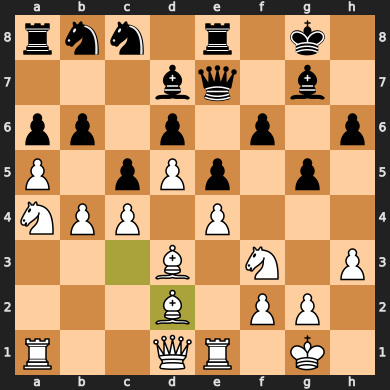

In [ ]:
board

In [ ]:
make_gif('board.gif', glob(f'boards/*.png'))

Ok, simple syntax/grammar works. Let’s try a slightly more interesting prompt:



In [ ]:
fill_mask("Jen la komenco de bela <mask>.")

# This is the beginning of a beautiful <mask>.
# =>

Exception: ignored

## 5. Share your model 🎉

Finally, when you have a nice model, please think about sharing it with the community:

- upload your model using the CLI: `transformers-cli upload`
- write a README.md model card and add it to the repository under `model_cards/`. Your model card should ideally include:
    - a model description,
    - training params (dataset, preprocessing, hyperparameters), 
    - evaluation results,
    - intended uses & limitations
    - whatever else is helpful! 🤓

### **TADA!**

➡️ Your model has a page on http://huggingface.co/models and everyone can load it using `AutoModel.from_pretrained("username/model_name")`.

[![tb](https://huggingface.co/blog/assets/01_how-to-train/model_page.png)](https://huggingface.co/julien-c/EsperBERTo-small)


If you want to take a look at models in different languages, check https://huggingface.co/models

[![all models](https://huggingface.co/front/thumbnails/models.png)](https://huggingface.co/models)
